### Imports

In [ ]:
# !pip install ipywidgets

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

### Functions

In [3]:
def transform_mousecentric(df, main_dir, mouse):
    '''
    Transforms data into mousecentric version
    '''
    
    folder_path = main_dir + "/Datasets/MouseCentric"
    file_path = f'/{mouse}_MouseCentric_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        mc_df = df.copy()
        mc_df = mc_df.iloc[:, 1:-1]
        mc_df = mc_df.astype(float)

        s1_x = mc_df.iloc[:,39].copy()
        s1_y = mc_df.iloc[:,40].copy()

        for column_index in range(0, len(mc_df.columns), 3):
            x_column = mc_df.columns[column_index]
            y_column = mc_df.columns[column_index+1]

            x = mc_df[x_column]
            y = mc_df[y_column]

            transformed_x = x - s1_x
            transformed_y = y - s1_y

            mc_df[x_column] = transformed_x
            mc_df[y_column] = transformed_y

        mc_df.iloc[:,39]=s1_x
        mc_df.iloc[:,40]=s1_y
        mc_df.insert(0, 'frame_number', df['frame_number'])
        mc_df['mouse_no'] = float(mouse)

        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mc_df.to_csv(folder_path + file_path, index=False)
        
    else:
        mc_df = pd.read_csv(folder_path + file_path)
        
    return mc_df
    
def transform_changecoord(df, main_dir, mouse):
    '''
    Transforms data into change coordinate version
    '''
    folder_path = main_dir + "/Datasets/ChangeCoords"
    file_path = f'/{mouse}_ChangeCoords_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        cc_df = df.copy()
        cc_df = cc_df.iloc[:, 1:-1]
        cc_df = cc_df.astype(float)

        for column_index in range(0, len(cc_df.columns), 3):
            x_column = cc_df.columns[column_index]
            y_column = cc_df.columns[column_index+1]

            cc_df[x_column] = cc_df[x_column] - cc_df[x_column].shift(1)
            cc_df[y_column] = cc_df[y_column] - cc_df[y_column].shift(1)

            cc_df[x_column] = cc_df[x_column].fillna(0)
            cc_df[y_column] = cc_df[y_column].fillna(0)

        cc_df.insert(0, 'frame_number', df['frame_number'])
        cc_df['mouse_no'] = float(mouse)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        cc_df.to_csv(folder_path + file_path, index=False)
        
    else:
        cc_df = pd.read_csv(folder_path + file_path)
    return cc_df
    
def transform_mcpolar(mc_df, main_dir, mouse):
    '''
    Transforms data into mouse centric polar coordinates version
    '''
    folder_path = main_dir + "/Datasets/MouseCentricPolar"
    file_path = f'/{mouse}_MouseCentricPolar_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        mcp_df = mc_df.copy()
        mcp_df = mcp_df.iloc[:,1:-1]
        mcp_df = mcp_df.astype(float)

        for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):
            x = mcp_df[col_x]
            y = mcp_df[col_y]

            r = np.sqrt(x**2 + y**2)
            theta = np.arctan2(y, x)

            mcp_df[col_x] = r
            mcp_df[col_y] = theta

        mcp_df.insert(0, 'frame_number', df['frame_number'])
        mcp_df['mouse_no'] = float(mouse)
        
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mcp_df.to_csv(folder_path + file_path, index=False)
    
    else:
        mcp_df = pd.read_csv(folder_path + file_path)
    
    return mcp_df
    
def transform_mcdirectional(mc_df, mcp_df, main_dir, mouse):
    '''
    Transforms data into mouse centric directional coordinates version
    '''
    folder_path = main_dir + "/Datasets/MouseDirectional"
    file_path = f'/{mouse}MouseDirectional_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        md_df = mc_df.copy()
        md_df = md_df.iloc[:,1:-1]
        md_df = md_df.astype(float)

        coordinates_columns = [col for col in md_df.columns if 'x' in col or 'y' in col]

        for frame_number, frame_data_polar in mcp_df.groupby('frame_number'):

            rotation_angle = frame_data_polar.at[frame_data_polar.index[0], "('S2', 'y')"]
            affine_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                      [np.sin(rotation_angle), np.cos(rotation_angle)]])

            for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):

                x = md_df[col_x]
                y = md_df[col_y]

                points = np.column_stack((x, y))
                transformed_points = np.dot(points[frame_number], affine_matrix)

                md_df.at[frame_number, col_x] = transformed_points[0]
                md_df.at[frame_number, col_y] = transformed_points[1]

        md_df.insert(0, 'frame_number', mc_df['frame_number'])
        md_df['mouse_no'] = float(mouse)
        
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        md_df.to_csv(folder_path + file_path, index=False)
    
    else:
        md_df = pd.read_csv(folder_path + file_path)
    
    return md_df

def transform_mcdirectionalpolar(md_df, main_dir, mouse):
    '''
    Transforms data into mouse centric directional polar coordinates version
    '''
    folder_path = main_dir + "/Datasets/MouseDirectionalPolar"
    file_path = f'/{mouse}MouseDirectionalPolar_data.csv'
    if not os.path.exists(folder_path + file_path):
        
        mdp_df = md_df.copy()
        mdp_df = mdp_df.iloc[:,1:-1]
        mdp_df = mdp_df.astype(float)
        
        coordinates_columns = [col for col in md_df.columns if 'x' in col or 'y' in col]
        
        for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):
            x = mdp_df[col_x]
            y = mdp_df[col_y]
            
            r = np.sqrt(x**2, y**2)
            theta = np.arctan2(y, x)
            
            mdp_df[col_x] = r
            mdp_df[col_y] = theta
            
        mdp_df.insert(0, 'frame_number', df['frame_number'])
        mdp_df['mouse_no'] = float(mouse)
        
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mdp_df.to_csv(folder_path + file_path, index=False)
    
    else:
        mdp_df = pd.read_csv(folder_path + file_path)
    
    return mdp_df

def create_dataset(main_dir: str, datatype: str):
    '''
    Creates data files with the given transformation type from the original data in the given main directory
    '''
    folder_path = main_dir + "/Datasets/Original"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    dataframes = []
    
    filtered_dir = os.path.join(main_dir, 'filtered')
    files = os.listdir(filtered_dir)
    
    for file in tqdm(files, desc="Processing Files"):
        mouse=file.split("_")[1]+"."+file.split("_")[2][0:-3]
        file=os.path.join(main_dir+'/filtered/', file)
        
        new_file_path = f'/{mouse}_Original_data.csv'
        if not os.path.exists(folder_path + new_file_path):
            df = pd.read_csv(file,header=[1,2])
            df.columns = ['frame_number'] + list(df.columns[1:])
            df['mouse_no'] = float(mouse)
            df.to_csv(folder_path + new_file_path, index=False)
        else:
            df = pd.read_csv(folder_path + new_file_path)

        if datatype == "Original":
            dataframes.append(df)
        elif datatype == "MouseCentric":
            mc_df = transform_mousecentric(df, main_dir, mouse)
            dataframes.append(mc_df)
        elif datatype == "MouseCentricPolar":
            mc_df = transform_mousecentric(df, main_dir, mouse)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse)
            dataframes.append(mcp_df)
        elif datatype == "ChangeCoord":
            cc_df = transform_changecoord(df, main_dir, mouse)
            dataframes.append(cc_df)
        elif datatype == "MouseDirectional":
            mc_df = transform_mousecentric(df, main_dir, mouse)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse)
            mcd_df = transform_mcdirectional(mc_df, mcp_df, main_dir, mouse)
            dataframes.append(mcd_df)
        elif datatype == "MouseDirectionalPolar":
            mc_df = transform_mousecentric(df, main_dir, mouse)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse)
            md_df = transform_mcdirectional(mc_df, mcp_df, main_dir, mouse)
            mdp_df = transform_mcdirectionalpolar(md_df, main_dir, mouse)
            dataframes.append(mdp_df)
    
    dataset = pd.concat(dataframes, ignore_index=True)
    
    return dataset

In [4]:
# Set the main folder to work from. This folder should have a subfolder called 'filtered' with all the unedited mouse csv files. The newly transformed data will then be put in corresponding subfolders in this main folder.
main_folder = "C:/Users/Kieran/Documents/Master Thesis test"

data_options = ["Original", "MouseCentric", "MouseCentricPolar", "ChangeCoord", "MouseDirectional", "MouseDirectionalPolar"]

dropdown = widgets.Dropdown(options=data_options, description='Select a data type:')
display(dropdown)

Dropdown(description='Select a data type:', options=('Original', 'MouseCentric', 'MouseCentricPolar', 'ChangeC…

In [5]:
datatype = dropdown.value
dataset = create_dataset(main_folder, datatype)
dataset

Processing Files: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.41it/s]


,frame_number,"('nose', 'x')","('nose', 'y')","('nose', 'likelihood')","('H1R', 'x')","('H1R', 'y')","('H1R', 'likelihood')","('H2R', 'x')","('H2R', 'y')","('H2R', 'likelihood')",...,"('tail', 'x')","('tail', 'y')","('tail', 'likelihood')","('S2', 'x')","('S2', 'y')","('S2', 'likelihood')","('S1', 'x')","('S1', 'y')","('S1', 'likelihood')",mouse_no
0,0,0.000000,0.000000,0.999969,0.000000,0.000000,0.999760,0.000000,0.000000,0.996968,...,0.000000,0.000000,0.998689,0.000000,0.000000,0.994912,0.000000,0.000000,0.995648,11.4
1,1,0.444275,2.021118,0.999950,0.536194,1.981354,0.999568,4.448181,4.355835,0.997916,...,1.670120,0.212906,0.999059,0.595001,0.076477,0.996069,3.630341,2.596069,0.993003,11.4
2,2,0.439880,3.892548,0.999945,0.945496,3.524902,0.999638,1.928741,0.726379,0.999153,...,0.798141,1.392517,0.999419,2.681183,0.000000,0.986211,3.590607,2.148987,0.987800,11.4
3,3,7.703064,0.000000,0.999765,5.919373,0.000000,0.999534,4.751312,0.000000,0.999468,...,1.855469,1.921738,0.999285,2.977997,0.041992,0.981083,3.765533,2.638062,0.994152,11.4
4,4,17.169312,0.000000,0.999855,20.999176,0.000000,0.999252,17.283508,0.000000,0.998945,...,0.000000,4.927261,0.999156,0.000000,0.000000,0.983985,1.823181,0.067993,0.995609,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102495,11245,1.339661,2.253326,0.999232,3.207214,5.388489,0.999924,3.782471,2.128571,0.999492,...,0.582886,0.000000,0.999563,0.424469,0.375305,0.998793,4.226929,0.000000,0.998882,88.3
1102496,11246,1.342590,4.823639,0.999680,1.945129,3.831635,0.999842,0.461548,1.584595,0.999562,...,0.348389,0.000000,0.999529,0.385101,0.000000,0.998716,0.232422,-0.049561,0.998840,88.3
1102497,11247,12.412659,0.000000,0.999622,9.379395,0.000000,0.999950,6.598083,2.645782,0.999656,...,-0.155914,-1.260956,0.999215,0.496552,-0.301575,0.999035,0.308044,0.000000,0.998980,88.3
1102498,11248,0.000000,0.000000,0.999570,0.000000,0.000000,0.999939,0.000000,0.000000,0.999616,...,0.000000,-0.214752,0.999225,0.000000,-0.073730,0.998865,0.000000,0.000000,0.998603,88.3


In [35]:
# Step 1: Generate random video indices
selected_video_indices = np.random.choice(range(1, 99), size=1, replace=False)
# This selects 5 random video indices between 1 and 98 (inclusive), ensuring no duplication

selected_videos = []

# Step 2: Create slices for each selected video
for video_index in selected_video_indices:
    # Calculate the starting and ending frame indices for the video
    start_frame = video_index * 11250
    end_frame = (video_index + 1) * 11250
    # Use .loc to create a slice by row index
    video_slice = dataset.loc[start_frame:end_frame - 1]
    selected_videos.append(video_slice)

# Step 3: Concatenate the selected videos to create a sub-dataset
sub_dataset = pd.concat(selected_videos, ignore_index=True)
# The resulting 'sub_dataset' contains the selected 5 videos, each with 11250 frames
sub_dataset

,frame_number,"('nose', 'x')","('nose', 'y')","('nose', 'likelihood')","('H1R', 'x')","('H1R', 'y')","('H1R', 'likelihood')","('H2R', 'x')","('H2R', 'y')","('H2R', 'likelihood')",...,"('tail', 'x')","('tail', 'y')","('tail', 'likelihood')","('S2', 'x')","('S2', 'y')","('S2', 'likelihood')","('S1', 'x')","('S1', 'y')","('S1', 'likelihood')",mouse_no
0,0,0.000000,0.000000,0.999797,0.000000,0.000000,0.999634,0.000000,0.000000,0.999591,...,0.000000,0.000000,0.999627,0.000000,0.000000,0.999487,0.000000,0.000000,0.999304,144.3
1,1,0.000000,2.910309,0.999840,0.000000,2.231506,0.999476,0.769104,0.556915,0.999551,...,0.169342,0.200806,0.999590,0.084076,0.000000,0.999573,1.263733,0.000000,0.999335,144.3
2,2,0.000000,0.000000,0.999640,0.000000,0.000000,0.999672,0.351486,0.000000,0.998771,...,2.178619,0.137573,0.999436,0.769501,0.000000,0.999613,0.328918,0.000000,0.999315,144.3
3,3,-2.252350,-0.214020,0.999852,-2.428680,-0.463074,0.998173,0.000000,-0.207275,0.997707,...,0.000000,0.066132,0.999569,1.753632,-0.023895,0.999793,1.754456,-1.488037,0.999416,144.3
4,4,-0.396698,-0.512268,0.999826,-0.830505,-1.768433,0.997529,-0.351486,-0.349640,0.997297,...,0.001862,0.516083,0.999523,2.401428,-0.441162,0.999833,1.616882,-0.394989,0.999265,144.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11245,11245,0.723358,0.439987,0.999935,0.304138,0.203461,0.999640,2.399414,0.461594,0.999131,...,0.712280,-0.967003,0.998517,0.000000,0.475449,0.998708,0.413849,0.059875,0.990854,144.3
11246,11246,0.662872,0.318588,0.999878,0.000000,0.427444,0.999732,0.000000,1.831284,0.998847,...,0.000000,0.000000,0.999128,0.000000,0.000000,0.998806,0.238617,0.000000,0.990253,144.3
11247,11247,0.225677,0.059937,0.999852,0.000000,0.000000,0.999680,0.000000,0.000000,0.998981,...,0.000000,0.000000,0.998208,-0.241638,0.000000,0.998536,0.170746,-0.155670,0.990084,144.3
11248,11248,-0.225677,0.000000,0.999456,-0.304138,-0.427444,0.999621,-1.720184,-1.831284,0.999264,...,-2.054749,0.000000,0.998777,-3.996277,0.000000,0.998575,-0.170746,-0.757309,0.998065,144.3


In [36]:
sub_dataset['mouse_no'].unique()

array([144.3])

In [6]:
%%time
import umap

# Assuming you have a 2D array or DataFrame named 'data' with your coordinates
# You might need to preprocess and scale your data before applying UMAP

# Create a UMAP model with desired hyperparameters
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)

# Fit the UMAP model to your data
umap_result = umap_model.fit_transform(dataset.iloc[:,1:-1])

# 'umap_result' now contains the lower-dimensional representation of your data
# np.save('G:/My Drive/Master thesis/umap_changecoords_data.npy', umap_result)

CPU times: total: 1h 29min 18s
Wall time: 12min 35s


In [ ]:
np.save('G:/My Drive/Master thesis/umap_changecoords_data.npy', umap_result)

In [ ]:
print(umap_result)
len(umap_result)

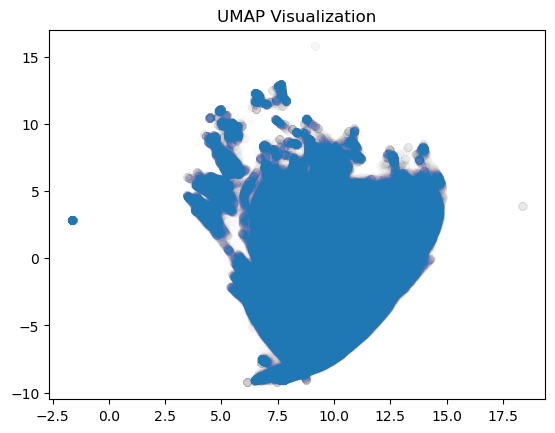

In [11]:
import matplotlib.pyplot as plt

# Assuming 'umap_result' contains your UMAP result
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.005)
plt.title("UMAP Visualization")
plt.show()

In [ ]:
from sklearn.cluster import HDBSCAN
import numpy as np

# Assuming 'umap_data' is your UMAP results, a 2D NumPy array

# Create an HDBSCAN clusterer with optional parameters
clusterer = HDBSCAN(min_samples=7, min_cluster_size=7)

# Fit the clusterer to your UMAP data
cluster_labels = clusterer.fit_predict(umap_result)

# Extract cluster labels
cluster_labels = clusterer.labels_

# Number of clusters found (excluding noise points)
num_clusters = len(np.unique(cluster_labels[cluster_labels != -1]))

# Display the number of clusters
print(f"Number of clusters: {num_clusters}")

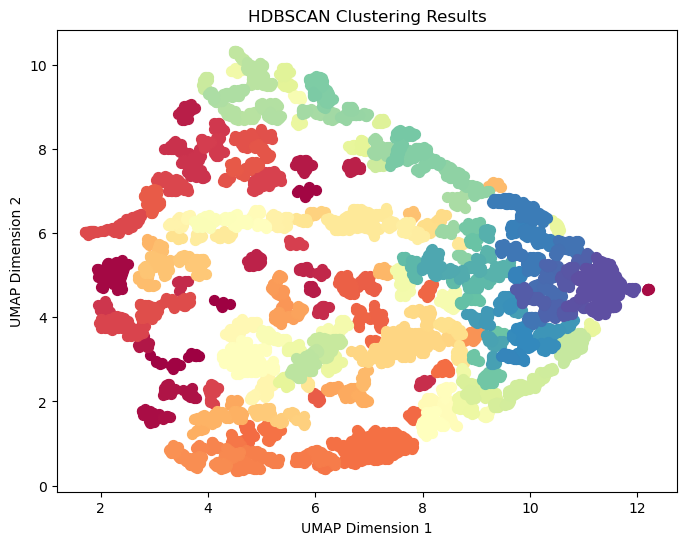

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'umap_data' is your UMAP results, a 2D NumPy array
# 'cluster_labels' is the cluster assignments obtained from HDBSCAN

# Create a scatter plot
plt.figure(figsize=(8, 6))

# Extract unique cluster labels (excluding noise points)
unique_clusters = np.unique(cluster_labels[cluster_labels != -1])

# Assign different colors to clusters
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

for cluster_label, color in zip(unique_clusters, colors):
    cluster_indices = np.where(cluster_labels == cluster_label)
    plt.scatter(umap_result[cluster_indices, 0], umap_result[cluster_indices, 1], label=f'Cluster {cluster_label}', c=[color], s=50)

# Add labels and title
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('HDBSCAN Clustering Results')

# Add a legend
# plt.legend()

# Display the plot
plt.show()


In [129]:
%%time
import umap

# Assuming you have a 2D array or DataFrame named 'data' with your coordinates
# You might need to preprocess and scale your data before applying UMAP

# Create a UMAP model with desired hyperparameters
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3)

# Fit the UMAP model to your data
umap_data = umap_model.fit_transform(sub_dataset.iloc[:,1:-1])

# 'umap_result' now contains the lower-dimensional representation of your data
# np.save('G:/My Drive/Master thesis/umap_changecoords_data.npy', umap_result)

CPU times: total: 4.16 s
Wall time: 2.48 s


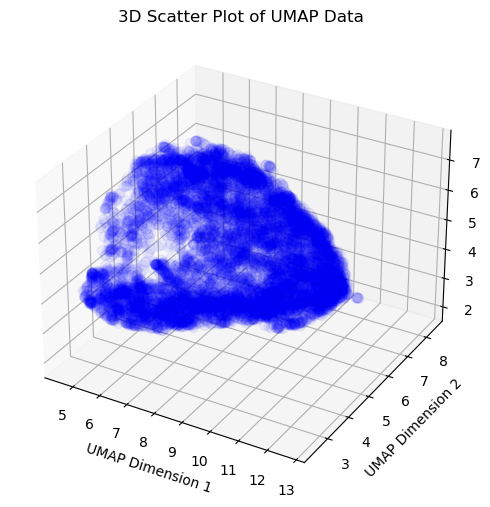

In [133]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract the X, Y, and Z coordinates from 'umap_data'
x = umap_data[:, 0]
y = umap_data[:, 1]
z = umap_data[:, 2]  # Assuming you have 3 dimensions in your UMAP data

# Create the scatter plot
ax.scatter(x, y, z, c='b', marker='o', s=50, alpha=0.05)

# Add labels and title
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
ax.set_title('3D Scatter Plot of UMAP Data')

# Display the plot
plt.show()

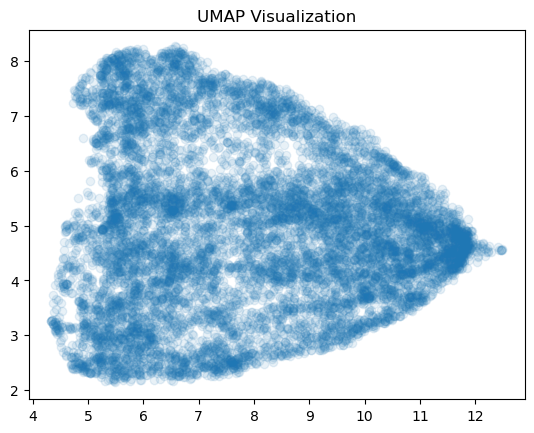

In [150]:
plt.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.1)
plt.title("UMAP Visualization")
plt.show()

In [156]:
# Create an HDBSCAN clusterer with optional parameters
clusterer = HDBSCAN(min_samples=4, min_cluster_size=5)

# Fit the clusterer to your UMAP data
cluster_labels = clusterer.fit_predict(umap_result)

# Extract cluster labels
cluster_labels = clusterer.labels_

# Number of clusters found (excluding noise points)
num_clusters = len(np.unique(cluster_labels[cluster_labels != -1]))

# Display the number of clusters
print(f"Number of clusters: {num_clusters}")

Number of clusters: 467


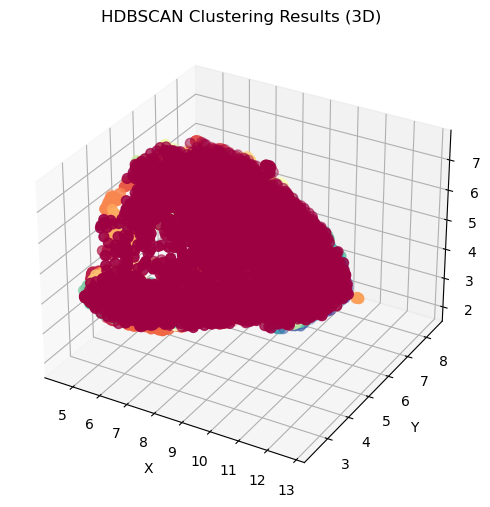

In [170]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract X, Y, and Z coordinates from 'umap_data_3d'
x = umap_data[:, 0]
y = umap_data[:, 1]
z = umap_data[:, 2]

# Extract unique cluster labels
unique_clusters = np.unique(cluster_labels)

# Create a colormap with a unique color for each cluster
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

# Plot data points with cluster colors
for cluster_label, color in zip(unique_clusters, colors):
    cluster_indices = np.where(cluster_labels == cluster_label)
    ax.scatter(x[cluster_indices], y[cluster_indices], z[cluster_indices], label=f'Cluster {cluster_label}', c=[color], s=50)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('HDBSCAN Clustering Results (3D)')

# Add a legend
# ax.legend()

# Display the plot
plt.show()

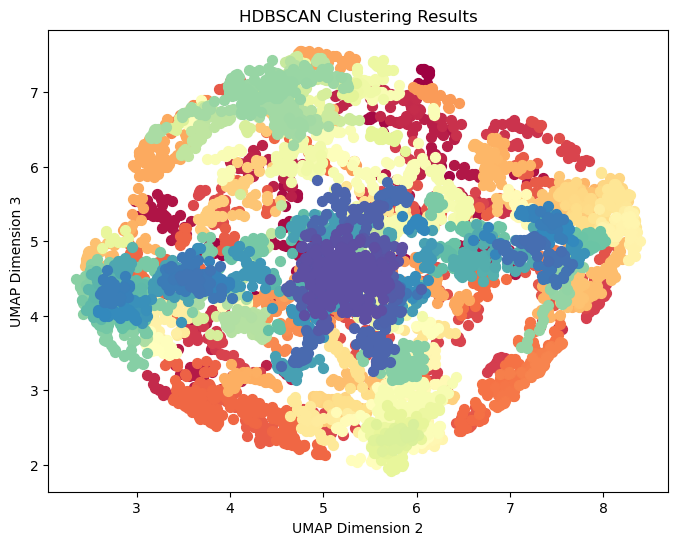

In [166]:
plt.figure(figsize=(8, 6))

# Extract unique cluster labels (excluding noise points)
unique_clusters = np.unique(cluster_labels[cluster_labels != -1])

# Assign different colors to clusters
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

for cluster_label, color in zip(unique_clusters, colors):
    cluster_indices = np.where(cluster_labels == cluster_label)
    plt.scatter(umap_data[cluster_indices, 1], umap_data[cluster_indices, 2], label=f'Cluster {cluster_label}', c=[color], s=50)

# Add labels and title
plt.xlabel('UMAP Dimension 2')
plt.ylabel('UMAP Dimension 3')
plt.title('HDBSCAN Clustering Results')

# Add a legend
# plt.legend()

# Display the plot
plt.show()

In [168]:
import numpy as np

# Assuming 'cluster_labels' is the cluster assignments obtained from HDBSCAN

# Count the number of data points in each cluster
unique_clusters, cluster_sizes = np.unique(cluster_labels, return_counts=True)

# Create a list of cluster labels and their corresponding sizes
cluster_info = list(zip(unique_clusters, cluster_sizes))

# Sort the clusters by size in descending order
sorted_clusters = sorted(cluster_info, key=lambda x: x[1], reverse=True)

# Select the top 5 largest clusters
top_5_clusters = sorted_clusters[:5]

# Extract the data points in the top 5 largest clusters
top_5_cluster_data = [umap_data[np.where(cluster_labels == label)] for label, size in top_5_clusters]

# Display the labels and sizes of the top 5 largest clusters
for label, size in top_5_clusters:
    print(f"Cluster Label: {label}, Cluster Size: {size}")

# You now have 'top_5_cluster_data' as a list containing the data points in the top 5 largest clusters


Cluster Label: -1, Cluster Size: 4887
Cluster Label: 465, Cluster Size: 280
Cluster Label: 88, Cluster Size: 171
Cluster Label: 248, Cluster Size: 107
Cluster Label: 250, Cluster Size: 95


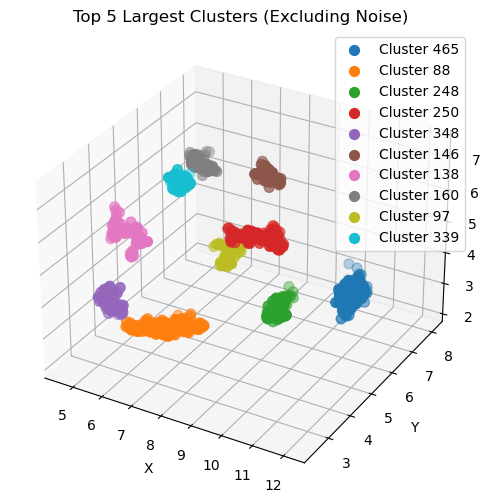

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'umap_data_3d' is your 3D dataset with X, Y, Z coordinates
# 'cluster_labels' is the cluster assignments obtained from HDBSCAN

# Get the cluster labels for the top 5 largest clusters (excluding noise points)
unique_clusters, cluster_sizes = np.unique(cluster_labels, return_counts=True)
cluster_info = list(zip(unique_clusters, cluster_sizes))
sorted_clusters = sorted(cluster_info, key=lambda x: x[1], reverse=True)
top_5_clusters = [label for label, size in sorted_clusters if label != -1][:10]

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points for the top 5 largest clusters
for cluster_label in top_5_clusters:
    cluster_indices = np.where(cluster_labels == cluster_label)
    ax.scatter(umap_data[cluster_indices, 0], umap_data[cluster_indices, 1], umap_data[cluster_indices, 2], label=f'Cluster {cluster_label}', s=50)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Top 5 Largest Clusters (Excluding Noise)')

# Add a legend
ax.legend()

# Display the plot
plt.show()


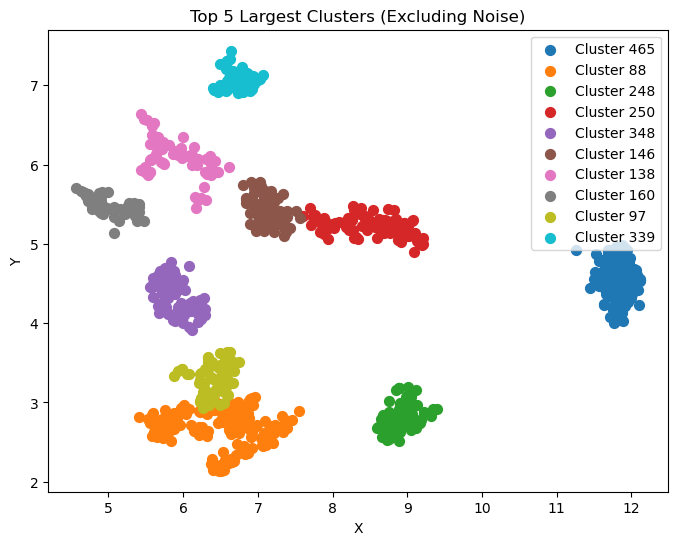

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'umap_data' is your 2D dataset with X and Y coordinates
# 'cluster_labels' is the cluster assignments obtained from HDBSCAN

# Get the cluster labels for the top 5 largest clusters (excluding noise points)
unique_clusters, cluster_sizes = np.unique(cluster_labels, return_counts=True)
cluster_info = list(zip(unique_clusters, cluster_sizes))
sorted_clusters = sorted(cluster_info, key=lambda x: x[1], reverse=True)
top_5_clusters = [label for label, size in sorted_clusters if label != -1][:10]

# Create a 2D scatter plot
plt.figure(figsize=(8, 6))

# Plot data points for the top 5 largest clusters
for cluster_label in top_5_clusters:
    cluster_indices = np.where(cluster_labels == cluster_label)
    plt.scatter(umap_data[cluster_indices, 0], umap_data[cluster_indices, 2], label=f'Cluster {cluster_label}', s=50)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Top 5 Largest Clusters (Excluding Noise)')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [1]:
import shutil
import os

# Source directory containing the files you want to copy
source_directory = 'Z:/Thesis_data/Data/Deeplabcut'

# Destination directory where you want to copy the files
destination_directory = 'C:/Users/Kieran/Documents/Master Thesis Data/labelled_videos'

# List all files in the source directory
files = os.listdir(source_directory)

# Filter the files to copy only those ending with "filtered_labeled.mp4"
files_to_copy = [f for f in files if f.endswith("filtered_labeled.mp4")]

# Copy the filtered files to the destination directory
for file in files_to_copy:
    source_path = os.path.join(source_directory, file)
    destination_path = os.path.join(destination_directory, file)
    shutil.copy(source_path, destination_path)

# Print a message when the copying is complete
print(f"Copied {len(files_to_copy)} files to the destination directory.")


Copied 98 files to the destination directory.
